# Identify Object Positions in Images - YOLO vs VLM 

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
# Access the API key using the variable name defined in the .env file
openai_api_key = os.getenv("OPENAI_API_KEY")
deepinfra_api_key = os.getenv("DEEPINFRA_API_KEY")
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")

google_api_key_g = os.getenv("GOOGLE_API_KEY_G")
openai_api_key_g = os.getenv("OPENAI_API_KEY_G")


In [2]:
# Import YOLO and load a pre-trained model
from ultralytics import YOLO

# Load the YOLOv8 pre-trained model
model = YOLO('yolov8n.pt')  # nano model for quick inference

# Get the class ID for the target object
target_object_name = "cup"  # Replace with your target object name
class_names = model.names
target_class_id = next((class_id for class_id, name in class_names.items() if name == target_object_name), None)


if target_class_id is not None:
    # Perform inference
    results = model('images/table_scene.jpeg', save = True)  # Replace with your image path

    # Filter bounding boxes for the target object
    detections = results[0].boxes
    specific_boxes = [
        box.xyxy[0].tolist()
        for box in detections
        if int(box.cls[0]) == target_class_id
    ]

    print(f"Bounding boxes for '{target_object_name}': {specific_boxes}")
else:
    print(f"Object name '{target_object_name}' not found in the model's class names.")


image 1/1 /workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 2 potted plants, 2 dining tables, 4 books, 3 vases, 1760.2ms
Speed: 102.6ms preprocess, 1760.2ms inference, 441.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict14
Bounding boxes for 'cup': [[615.28662109375, 553.363525390625, 845.9586181640625, 780.4920654296875]]


### Utils 


In [3]:

import json
import re
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

#this function is needed to plot bounding boxes on images 
def plot_bounding_boxes(im, positions, noun_phrase=None):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Try to load a TrueType font for larger labels, fallback to default
    try:
        font = ImageFont.truetype("arial.ttf", size=24)
    except Exception:
        font = ImageFont.load_default()

    # Define a list of colors
    colors = [
        'red',
        'green',
        'blue',
        'yellow',
        'orange',
    ] + additional_colors

    for i, item in enumerate(positions):
        # Support entries of the form: [y1,x1,y2,x2] or (label, [y1,x1,y2,x2])
        if isinstance(item, (list, tuple)) and len(item) == 2 and isinstance(item[0], str):
            label = item[0]
            try:
                y1, x1, y2, x2 = item[1]
            except Exception:
                continue
        else:
            label = noun_phrase if noun_phrase is not None else ""
            try:
                y1, x1, y2, x2 = item
            except Exception:
                continue

        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)
        if label:
            draw.text((abs_x1 + 8, abs_y1 + 6), str(label), fill=color, font=font)

    # Display the image
    img.show()

# if the boxes coordinates are output not as json but as text, should be parsed first
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result



# VLM (1): OPEN-AI

In [4]:
import openai
from dotenv import load_dotenv  
import base64

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

load_dotenv()
openAIclient = openai.OpenAI(api_key=openai_api_key)

img = "images/table_scene.jpeg"


In [5]:
#basic call to gpt4 with prompt and image

import json

completion = openAIclient.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Detect if there is a cup in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax], normalize the coordinate to 0-1000. Just output the list in json."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                    }
                },
            ],
        }
    ],
    response_format={"type": "json_object"},
)

# Wrap the text to a specified width
response = str(completion.choices[0].message.content)



Load answer in a python dict and/or parse the json before if needed

In [6]:
detection = json.loads(response)

In [7]:
detection

{'coordinates': [500, 730, 800, 930]}

now parse and plot bounding boxes. Consider the format the utils function want the bounding boxes to be plotted!

[[500, 730, 800, 930]]
(1024, 1024)


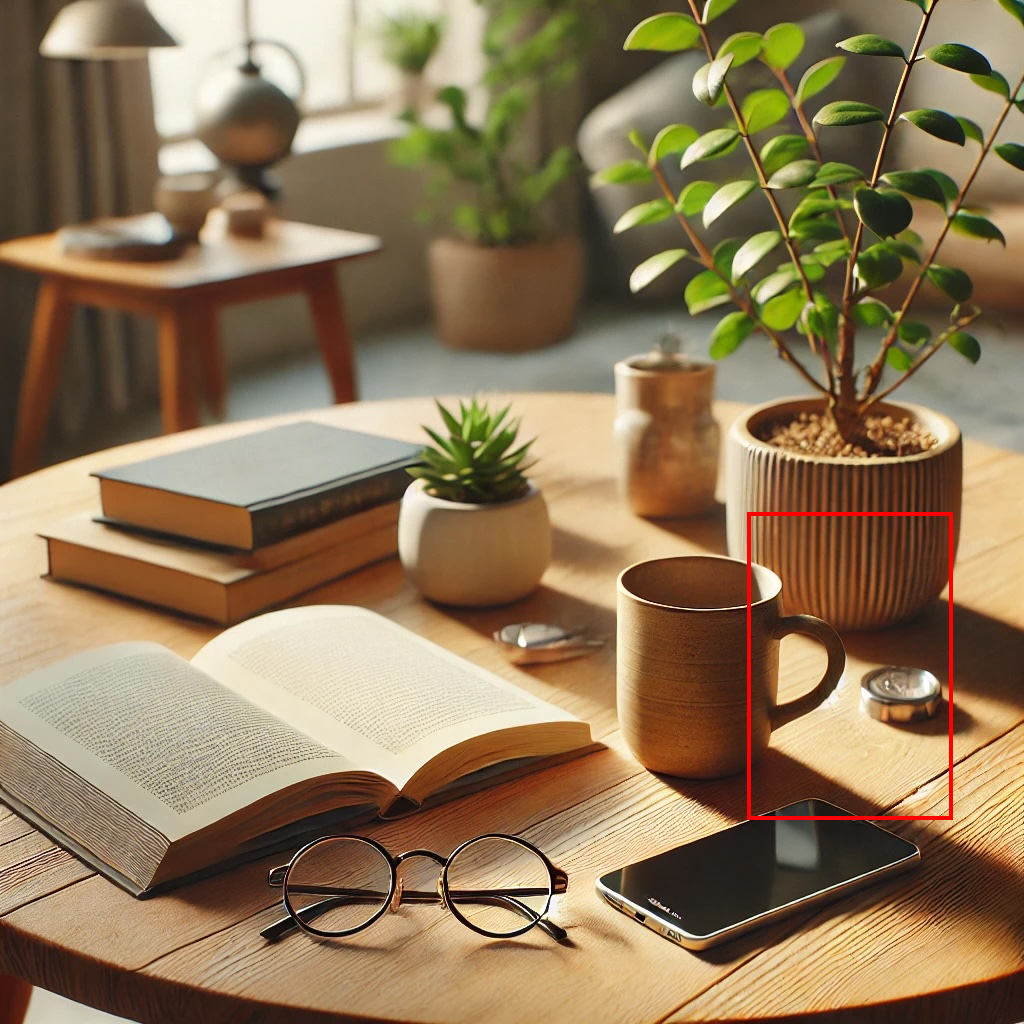

In [8]:
#boxes= parse_list_boxes(str(detection['coordinates'])) #depending whether you managed to output a json or not. If your output is still in "str" form you might need to parse it with this util function
boxes= [detection['coordinates']]
print(boxes)
plot_bounding_boxes(Image.open(img), positions=list(boxes))

# VLM (2): GEMINI


In [9]:
%matplotlib inline
from dotenv import load_dotenv  
from google import genai
from PIL import Image

load_dotenv()
client = genai.Client(api_key=google_api_key_g)


In [14]:
im = Image.open(img)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[
        im,
        (
            "Detect if there is a cup in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax], normalize the coordinate to 0-1000. answer should be json format only"
        ),
        
    ],
    config={"response_mime_type": "application/json"}
)

print(response.text)


[
  {"box_2d": [542, 600, 758, 826], "label": "cup"}
]


Ah! Output is a list! because I asked for it in the prompt - either you leave it and take account in parsing, or you remove the word "list" in prompt.

In [15]:
json.loads(response.text)

[{'box_2d': [542, 600, 758, 826], 'label': 'cup'}]

(1024, 1024)


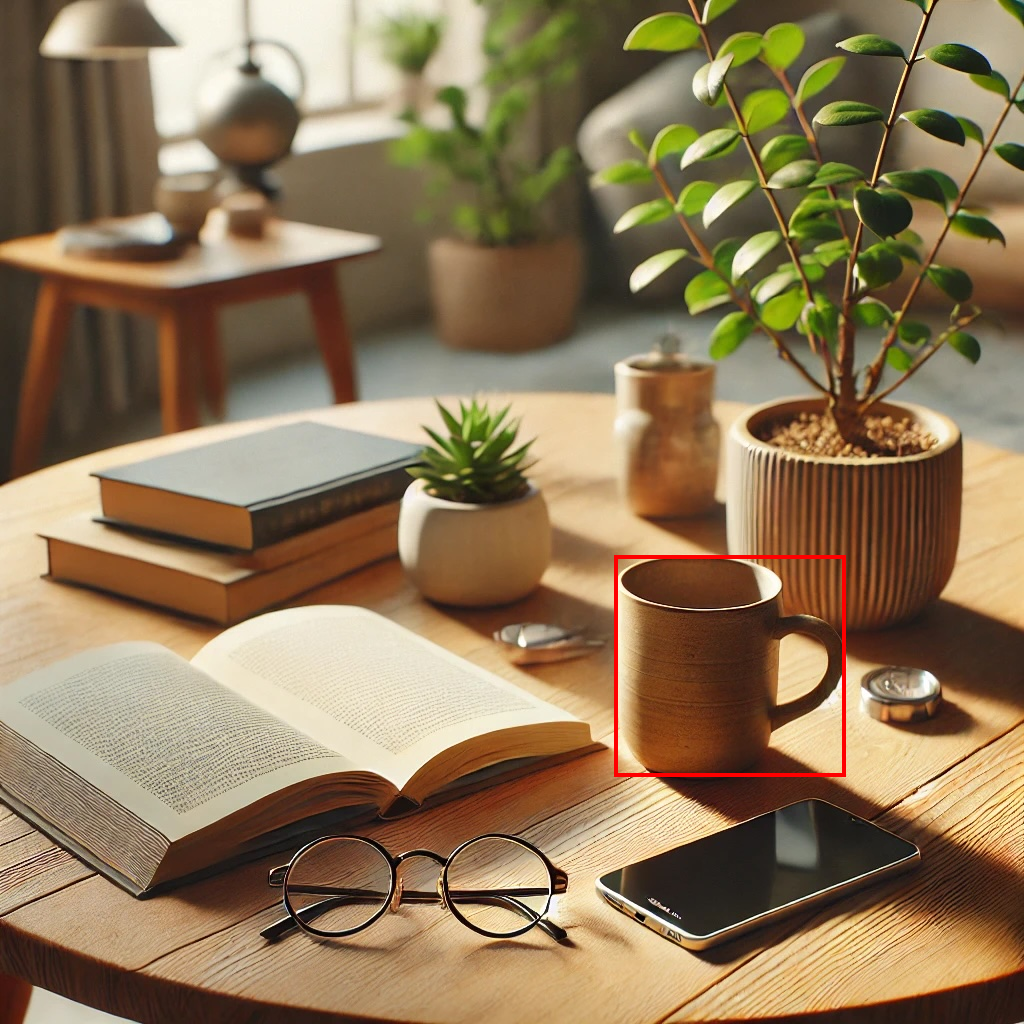

In [16]:
#boxes= parse_list_boxes(response.text) # same comment as above
box_coord = [json.loads(response.text)[0]['box_2d']] #due to the fact it is a list, otherwise this line might change
plot_bounding_boxes(im,positions=list(box_coord))

(1024, 1024)


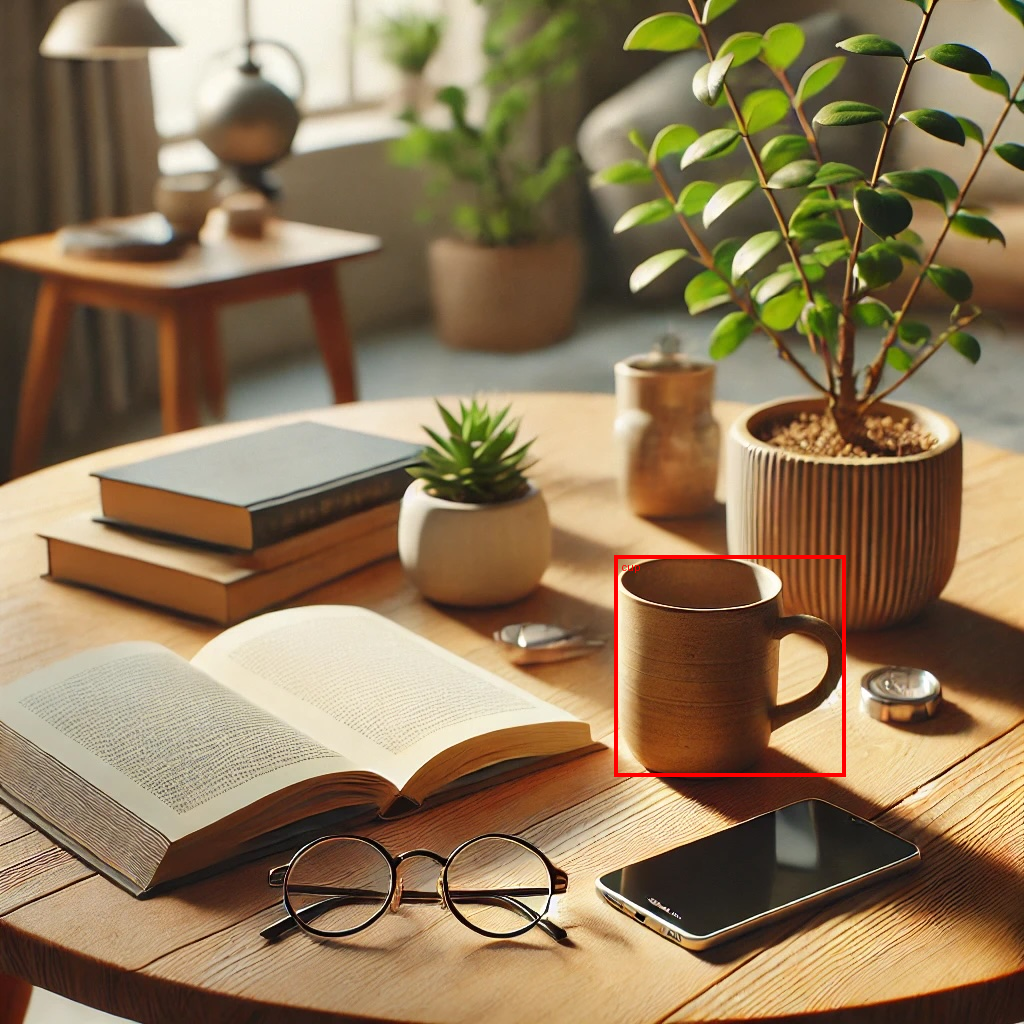

In [17]:
data = json.loads(response.text)
entry = data[0]
box_coord = [entry['box_2d']]
label = entry.get('label')   # 'cup'
plot_bounding_boxes(im, positions=box_coord, noun_phrase=label)

## Multiple objects at once

In [18]:
# Prompt Gemini to detect multiple objects (cup, plant, book)
im = Image.open(img)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[
        im,
        (
            "Detect whether there is a cup, plant, and book in the image and return a JSON array of detections only one detection per object. "
            "Each detection must be an object with keys 'label' and 'box_2d' where 'box_2d' is [ymin,xmin,ymax,xmax] "
            "normalized to 0-1000. ONLY return valid JSON (no explanatory text)."
        ),
    ],
    config={"response_mime_type": "application/json"}
)

print(response.text)


[
  {
    "label": "cup",
    "box_2d": [541, 599, 757, 821]
  },
  {
    "label": "plant",
    "box_2d": [5, 601, 617, 995]
  },
  {
    "label": "book",
    "box_2d": [588, 0, 887, 584]
  }
]


In [19]:
json.loads(response.text)


[{'label': 'cup', 'box_2d': [541, 599, 757, 821]},
 {'label': 'plant', 'box_2d': [5, 601, 617, 995]},
 {'label': 'book', 'box_2d': [588, 0, 887, 584]}]

Detected: [('cup', [541, 599, 757, 821]), ('plant', [5, 601, 617, 995]), ('book', [588, 0, 887, 584])]
(1024, 1024)


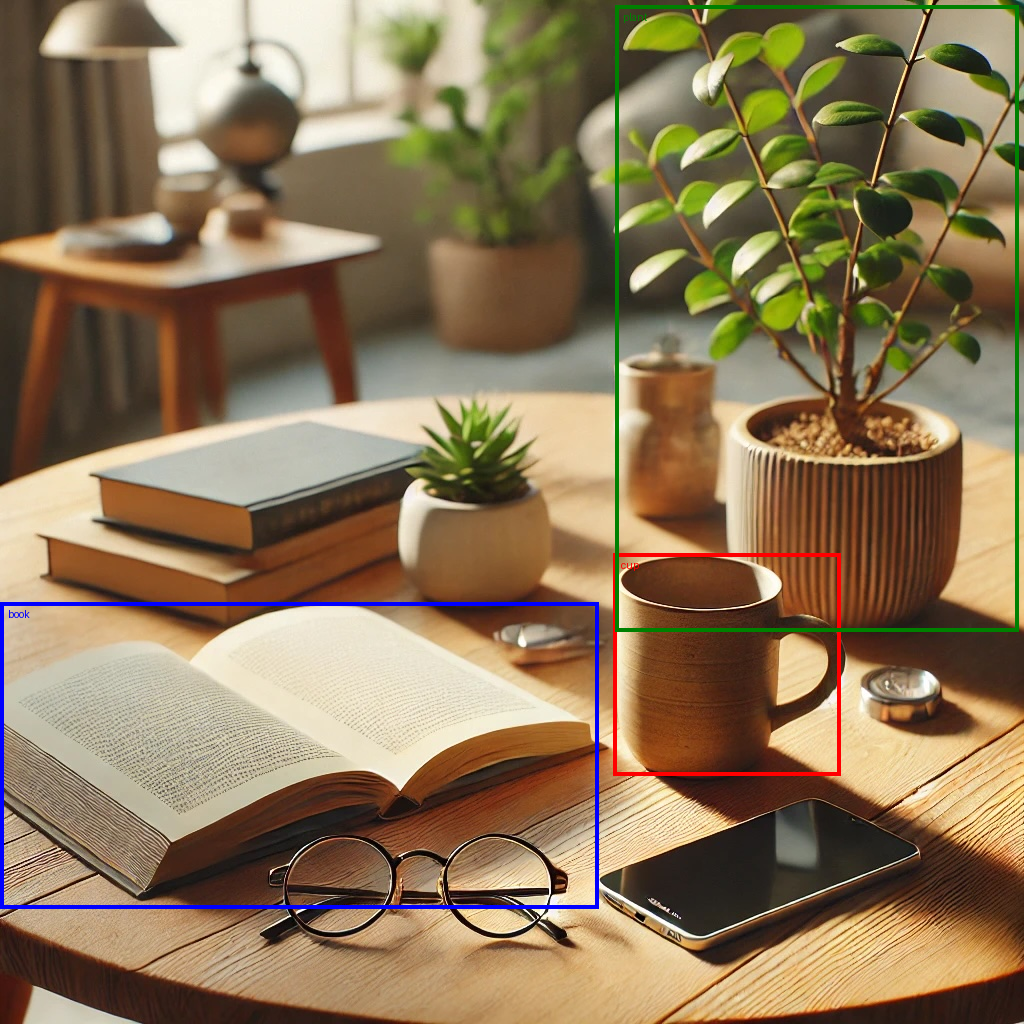

In [20]:
import json
from PIL import Image

# Parse the model response (must run the prompt cell first)
try:
    data = json.loads(response.text)
except Exception as e:
    print("Failed to parse response.text:", e)
    data = []

# Build labeled positions expected by the util: (label, box)
positions = [(entry.get('label', ''), entry.get('box_2d')) for entry in data if entry.get('box_2d')]

if positions:
    print('Detected:', [(p[0], p[1]) for p in positions])
    plot_bounding_boxes(Image.open(img), positions=positions)
else:
    print('No detections parsed from response.text')
